In [1]:
#standard libraries
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import re
import pickle
from unidecode import unidecode
import matplotlib.pyplot as plt

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

#nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter
from langdetect import detect

#preprocessing and feature extraction
import helper

#tensorflow
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import FeatureSpace

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split



import random
random.seed(42)

In [2]:
df = pd.read_csv(parent_dir + '\\' + 'data/online_ship_listing_data.csv')

In [3]:
#splitting the dataframe
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1184 train examples
296 validation examples
370 test examples


In [4]:
def df_to_dataset(df, shuffle=True, batch_size=32):
    df = df.copy()
    
    df = helper.preprocess_df(df)
    df, all_cols = helper.create_features(df)
    labels = df.pop('price')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds, all_cols

In [5]:
#convert dataframe to dataset
batch_size = 32
train_ds, all_cols = df_to_dataset(train)
val_ds, _ = df_to_dataset(val, shuffle=False, batch_size=batch_size)

C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['word_count'], axis=1, inplace=True)
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_language'] = df['description'].apply(lambda x:detect(x))
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [6]:
#sanity checking
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of fuel tank:', feature_batch['fuel_type'])
    print('A batch of country:', feature_batch['country'])
    print('A batch of model:', feature_batch['category'])
    print('A batch of targets:', label_batch)

Every feature: ['year', 'model', 'category', 'length', 'fuel_type', 'hull_material', 'country', 'noun_counts', 'verb_counts', 'adjective_counts', 'bilge_pump', 'deck_finish', 'fuel_tank', 'good_condition', 'level_indicator', 'material_grp', 'sailing_yacht', 'stainless_steel', 'tank_litre', 'teak_cockpit', 'avg_price_by_hull_material', 'avg_price_by_fuel_type', 'avg_price_by_category']
A batch of fuel tank: tf.Tensor(
[b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'electrical'
 b'petrol' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel'
 b'diesel' b'petrol' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel'
 b'diesel' b'petrol' b'diesel' b'electrical' b'diesel' b'diesel' b'diesel'
 b'diesel' b'diesel' b'petrol' b'diesel'], shape=(32,), dtype=string)
A batch of country: tf.Tensor(
[b'poland' b'afghanistan' b'italy' b'afghanistan' b'afghanistan'
 b'afghanistan' b'germany' b'afghanistan' b'afghanistan' b'afghanistan'
 b'italy' b'germany' b'netherlands' b'germany' b'

In [7]:
fileName = parent_dir + '\\' + 'model/column_names.pkl'
with open(fileName,'wb') as f:
    pickle.dump(all_cols,f)

In [8]:
float_normalized_cols = ['length', 'noun_counts', 'verb_counts', 'adjective_counts', 'avg_price_by_hull_material',
                        'avg_price_by_fuel_type', 'avg_price_by_category']
float_cols = ['bilge_pump', 'deck_finish', 'fuel_tank', 'level_indicator', 'material_grp', 'mehr_anzeigen',
             'sailing_yacht', 'stainless_steel', 'tank_litre', 'teak_cockpit']
string_categorical_cols = ['model', 'category', 'hull_material', 'country', 'fuel_type']
float_discretized_cols = ['year']

float_normalized = 'float_normalized'
just_float = 'float'
string_categorical = 'string_categorical'
float_discretized = 'float_discretized'

In [9]:
all_keys = sorted(float_normalized_cols + float_cols + string_categorical_cols)
features_dict = {key: float_normalized if key in float_normalized_cols else (just_float if key in float_cols else string_categorical) for key in all_keys}

In [10]:
features_dict['year'] = FeatureSpace.float_discretized(num_bins=10)

In [11]:
features_dict

{'adjective_counts': 'float_normalized',
 'avg_price_by_category': 'float_normalized',
 'avg_price_by_fuel_type': 'float_normalized',
 'avg_price_by_hull_material': 'float_normalized',
 'bilge_pump': 'float',
 'category': 'string_categorical',
 'country': 'string_categorical',
 'deck_finish': 'float',
 'fuel_tank': 'float',
 'fuel_type': 'string_categorical',
 'hull_material': 'string_categorical',
 'length': 'float_normalized',
 'level_indicator': 'float',
 'material_grp': 'float',
 'mehr_anzeigen': 'float',
 'model': 'string_categorical',
 'noun_counts': 'float_normalized',
 'sailing_yacht': 'float',
 'stainless_steel': 'float',
 'tank_litre': 'float',
 'teak_cockpit': 'float',
 'verb_counts': 'float_normalized',
 'year': <keras.src.utils.feature_space.Feature at 0x28dd3245a90>}

In [12]:
feature_space = FeatureSpace(
    features={
    "adjective_counts": 'float_normalized',
    "avg_price_by_category": 'float_normalized',
    "avg_price_by_fuel_type": 'float_normalized',
    "avg_price_by_hull_material": 'float_normalized',
    "bilge_pump": 'float',
    "category": 'string_categorical',
    "country": 'string_categorical',
    "deck_finish": 'float',
    "fuel_tank": 'float',
    "fuel_type": 'string_categorical',
    "hull_material": 'string_categorical',
    "length": 'float_normalized',
    "level_indicator": 'float',
    "material_grp": 'float',
    "good_condition": 'float',
    "model": 'string_categorical',
    "noun_counts": 'float_normalized',
    "sailing_yacht": 'float',
    "stainless_steel": 'float',
    "tank_litre": 'float',
    "teak_cockpit": 'float',
    "verb_counts": 'float_normalized',
    "year": FeatureSpace.float_discretized(num_bins=10)
    },
    output_mode="concat",
    crosses=[
        FeatureSpace.cross(feature_names=("model", "category"), crossing_dim=64),
        FeatureSpace.cross(feature_names=("hull_material", "category"), crossing_dim=16),
        FeatureSpace.cross(feature_names=("fuel_type", "category"), crossing_dim=16),
        
    ],
)

#needs to adapt the feature_space. Reminder: feature_space needs to be adapted to a dataset WITHOUT LABEL
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [13]:
feature_space.save(parent_dir + '\\' + 'model/feature_space.keras')

In [14]:
#checking the dataset shape
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 977)
preprocessed_x.dtype: <dtype: 'float32'>


In [15]:
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [16]:
#remapping to label
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

#To make sure the training data is read infinitely
preprocessed_train_ds = preprocessed_train_ds.repeat()

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

In [17]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()
x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x) #using dropout layer to avoid overfitting
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="linear")(x)

#1st model: training_model
training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="mse", metrics=[rmse, "mse"]
)

#2nd model: inference_model
inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [18]:
TRAIN_BATCH_SIZE = 32 
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 500
NUM_EVAL_EXAMPLES = 14906

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
#early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [19]:
#training the model
history = training_model.fit(preprocessed_train_ds,
                    validation_data=preprocessed_val_ds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping]
                    )

Epoch 1/500
18/18 [==============================] - 2s 33ms/step - loss: 59486797824.0000 - rmse: 242018.7812 - mse: 59486797824.0000 - val_loss: 36444467200.0000 - val_rmse: 187765.0469 - val_mse: 36444467200.0000
Epoch 2/500
18/18 [==============================] - 0s 21ms/step - loss: 60876623872.0000 - rmse: 242594.5312 - mse: 60876623872.0000 - val_loss: 36362235904.0000 - val_rmse: 187549.8906 - val_mse: 36362235904.0000
Epoch 3/500
18/18 [==============================] - 0s 21ms/step - loss: 63101878272.0000 - rmse: 248253.8594 - mse: 63101878272.0000 - val_loss: 34871877632.0000 - val_rmse: 183617.2969 - val_mse: 34871877632.0000
Epoch 4/500
18/18 [==============================] - 0s 20ms/step - loss: 61865320448.0000 - rmse: 245054.2188 - mse: 61865320448.0000 - val_loss: 22775672832.0000 - val_rmse: 148117.7031 - val_mse: 22775672832.0000
Epoch 5/500
18/18 [==============================] - 0s 19ms/step - loss: 29616365568.0000 - rmse: 169813.3750 - mse: 29616365568.0000 -

18/18 [==============================] - 0s 19ms/step - loss: 5413873664.0000 - rmse: 71944.7891 - mse: 5413873664.0000 - val_loss: 4482043392.0000 - val_rmse: 64548.0820 - val_mse: 4482043392.0000
Epoch 40/500
18/18 [==============================] - 0s 22ms/step - loss: 5136890880.0000 - rmse: 69349.8672 - mse: 5136890880.0000 - val_loss: 4286487040.0000 - val_rmse: 62590.5938 - val_mse: 4286487040.0000
Epoch 41/500
18/18 [==============================] - 0s 20ms/step - loss: 6492551680.0000 - rmse: 77329.7891 - mse: 6492551680.0000 - val_loss: 4335639552.0000 - val_rmse: 63093.0703 - val_mse: 4335639552.0000


In [20]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right');    

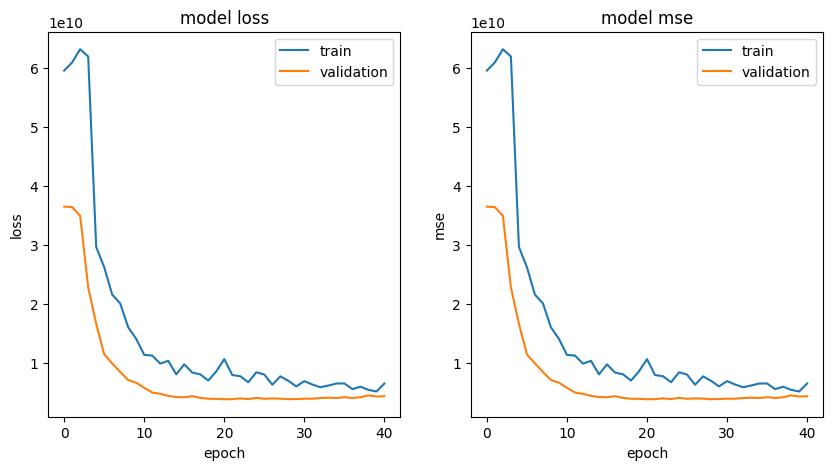

In [21]:
plot_curves(history, ['loss', 'mse'])

In [22]:
#creating a sample data
sample = {
    "year":tf.convert_to_tensor([2010.]),
    "model":tf.convert_to_tensor(['gulet']),
    "category":tf.convert_to_tensor(['schoner']),
    "length":tf.convert_to_tensor([83.]),
    "fuel_type":tf.convert_to_tensor(['diesel']),
    "hull_material":tf.convert_to_tensor(['steel']),
    "country":tf.convert_to_tensor(['turkey']),
    "noun_counts":tf.convert_to_tensor([20.]),
    "verb_counts":tf.convert_to_tensor([20.]),
    "adjective_counts":tf.convert_to_tensor([20.]),
    "bilge_pump":tf.convert_to_tensor([1.]),
    "deck_finish":tf.convert_to_tensor([0.]),
    "fuel_tank":tf.convert_to_tensor([1.]),
    "level_indicator":tf.convert_to_tensor([1.]),
    "material_grp":tf.convert_to_tensor([0.]),
    "good_condition":tf.convert_to_tensor([0.]),
    "sailing_yacht":tf.convert_to_tensor([1.]),
    "stainless_steel":tf.convert_to_tensor([0.]),
    "tank_litre":tf.convert_to_tensor([1.]),
    "teak_cockpit":tf.convert_to_tensor([1.]),
    "avg_price_by_hull_material":tf.convert_to_tensor([173764.8396226415]),
    "avg_price_by_fuel_type":tf.convert_to_tensor([172121.64462209304]),
    "avg_price_by_category":tf.convert_to_tensor([476125.0]),
    
}

In [23]:
from tensorflow.keras.models import save_model, load_model

In [24]:
inference_model.save(parent_dir + '\\' + "model/inference_model.keras")
reconstructed_model = load_model(parent_dir + '\\' + "model/inference_model.keras")
reconstructed_model.predict(sample)

1/1 [==============================] - 0s 481ms/step


array([[2539680.2]], dtype=float32)

In [25]:
test_temp = helper.preprocess_df(test)
df_test,_ = helper.create_features(test_temp)

C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['word_count'], axis=1, inplace=True)
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_language'] = df['description'].apply(lambda x:detect(x))


In [26]:
test_price = df_test.price.tolist()
df_test.drop('price', axis=1,inplace=True)

In [27]:
list_of_dicts = [row.to_dict() for _, row in df_test.iterrows()]

In [28]:
predicted_price = []
for i in list_of_dicts:
    #convert the value of the dictionary to tensor
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in i.items()}
    predictions = inference_model.predict(input_dict)
    predicted_price.append(predictions[0][0])

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


In [29]:
from sklearn.metrics import mean_squared_error

#appending the quantity and predicted quantity to the dataframe
df_test['price'] = test_price
df_test['predicted_price'] = predicted_price
rmse = np.sqrt(mean_squared_error(df_test['price'], df_test['predicted_price']))

print('The resulting RMSE for the test dataset is: ', rmse)

The resulting RMSE for the test dataset is:  85713.7221992151


In [30]:
reconstructed_model = load_model(parent_dir + '\\' + "model/inference_model.keras")
reconstructed_model.predict(sample)

1/1 [==============================] - 0s 457ms/step


array([[2539680.2]], dtype=float32)

In [31]:
reconstructed_model.compile(
    optimizer="adam", loss="mse", metrics=[rmse, "mse"]
)

In [32]:
reconstructed_model.save(parent_dir + '\\' + 'model/tf_inference_model', save_format='tf')

INFO:tensorflow:Assets written to: C:\Online Course\Projects\shipping-listing-price-prediction\model/tf_inference_model\assets


INFO:tensorflow:Assets written to: C:\Online Course\Projects\shipping-listing-price-prediction\model/tf_inference_model\assets


In [33]:
reconstructed_model.predict(sample)

1/1 [==============================] - 0s 455ms/step


array([[2539680.2]], dtype=float32)

In [34]:
feature_space